# Подготовка отчета о проведенном исследовании
## Введение
В данном отчете я представлю результаты исследований предсказания оттока пользователей. В качестве набора данных взята клиентская база, которую предоставила французская телекоммуникационная компания Orange. Данные были предварительно обфусцированы и анонимизированны: из датасета убрана любая персональная информация, позволяющая идентифицировать пользователей, а также не представлены названия и описания переменных, предназначенных для построения прогнозов. Набор данных состоит из 40 тыс. объектов и 230 признаков, 190 из которых - числовые, а оставшиеся 40 - категориальные.
## Цели и задачи проекта
Цель проекта - научиться находить пользователей, склонных к оттоку. 

Задачи:
- Построить модель классификации, которая будет выявлять пользователей, склонных к оттоку;
- Использовать обученную модель для нахождения новых пользователей, склонных к оттоку.

Используя мою модель, можно заблаговременно находить пользователей, склонных к оттоку. После их нахождения можно выявить причины оттока или попытаться провести кампанию по удержанию.

In [52]:
# манипуляции с данными
import pandas as pd
import numpy as np

# визуализация данных
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn

# модель машинного обучения
from catboost import CatBoostClassifier

# оценка модели
from sklearn.model_selection import learning_curve, StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, precision_score

In [2]:
# загрузка данных
data_train = pd.read_csv('data_train.csv')
data_test = pd.read_csv('hold_out_dataset.csv')

## Методика измерения качества и критерий успеха
Оценка модели проводится по метрике ROC AUC. Чем ближе ее значение к 1, тем качественнее модель получается. Однако существует риск переобучения. Для борьбы с ним обучение проходит с помощью кросс-валидации, а выводы о качестве модели делаются по значению метрики на отложенной выборке. 

## Техническое описание решения
Прежде чем применить модель машинного обучения необходимо сделать несколько шагов предобработки:
1. Удалить все признаки, у которых все значения пропущены;
2. Заполнить пропущенные признаки по следующей стратегии:
   - пропуски числовых признаков заполнить нулевыми значениями;
   - пропуски категориальных признаков заменить как новую категорию "NA".
   
В качестве модели используется алгоритм градиентного бустинга на деревьях решений, реализованный в библиотеке catboost. Данная реализация была выбрана, так как в данной задаче критерием успеха является правильная обработка категориальных признаков, а CatBoostClassifier не требует предварительной обработки категориальных признаков, а обрабатывает их сам внутри. На вход модели подаются следующие параметры:
- специально посчитанный баланс классов;
- 300 деревьев;
- глубина каждого дерева равна 2;
- длина шага градиентного спуска равна 0.1.

In [3]:
# баланс классов
churn = data_train[data_train.y == 1].shape[0] # число клиентов класса "отток"
not_churn = data_train[data_train.y == -1].shape[0] # число клиентов класса "не отток"
all_ = data_train.shape[0] # число всех клиентов
class_weights = [all_ / (2 * not_churn), all_ / (2 * churn)]

In [4]:
# заполнение пропусков
def fill_missing_values(df):
    num_columns = [c for c in num_col if c in df.columns]
    df_num = df[num_columns].fillna(0)
    df_cat = df[cat_columns].fillna("NA", axis=0)
    X = pd.concat([df_num, df_cat], axis=1)
    return X

In [5]:
# разделение признаков на числовые и категориальные
num_col = data_train.columns[1:190]
cat_col = data_train.columns[190:-1]

# удаление признаков, у которых все значения пропущены
drop_col = data_train.count(axis=0)[data_train.count(axis=0) == 0].index # столбцы, у которых все значения пропущены
data_train = data_train.drop(drop_col, axis=1)
data_test = data_test.drop(drop_col, axis=1)

# оставшиеся категориальные признаки
cat_columns = [c for c in cat_col if c in data_train.columns]

# заполнение пропущенных значений
X = fill_missing_values(data_train)
y = data_train.y

X_test = fill_missing_values(data_test)
y_test = data_test.y

# построение и обучение модели
cv = StratifiedKFold(shuffle=True)
model = CatBoostClassifier(iterations=300,
                           learning_rate=0.1,
                           depth=2,
                           cat_features=cat_columns,
                           verbose=False)
opt = GridSearchCV(model, param_grid={'class_weights': [class_weights, None]}, scoring='roc_auc', n_jobs=-1, cv=cv)
opt.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x00000211521347C0>,
             n_jobs=-1,
             param_grid={'class_weights': [[0.540321491287316,
                                            6.700167504187605],
                                           None]},
             scoring='roc_auc')

In [12]:
# оценка качества модели
roc_auc_score(y_test, opt.predict_proba(X_test)[:, 1])

0.7222299470246814

На этом не останавливаюсь. Удалю объекты, которые имеют "наибольшую" ошибку при прогнозировании, а также те объекты, у которых менее 53 заполненных значений.

In [13]:
# создание таблицы, состоящей из двух столбцов
# в первом столбце указаны вероятности принадлежности объектов к классу "отток"
# во втором столбце указаны истинные метки
result = pd.DataFrame({'probability': opt.predict_proba(X)[:, 1], 'labels': y})

# объекты, которые имеют "наибольшую" ошибку при прогнозировании
error = result[((result.probability > 0.9) & (result.labels == -1)) | 
               ((result.probability < 0.1) & (result.labels == 1))]
new_X = X.drop(error.index, axis=0)
new_y = y.drop(error.index)

# объекты, у которых менее 53 заполненных значений
poor_obj = data_train.count(axis=1)[data_train.count(axis=1) < 53].index
X_2 = new_X.drop(poor_obj, axis=0)
y_2 = new_y.drop(poor_obj)

# обучение модели
opt.fit(X_2, y_2)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x00000211521347C0>,
             n_jobs=-1,
             param_grid={'class_weights': [[0.540321491287316,
                                            6.700167504187605],
                                           None]},
             scoring='roc_auc')

In [14]:
# оценка качества модели
roc_auc_score(y_test, opt.predict_proba(X_test)[:, 1])

0.724698136135188

## Интерпретация модели
CatBoostClassifier дает неплохое качество по метрике ROC AUC на отложенной выборке. Однако часто хочется проинтерпретировать результаты, чтобы улучшать некоторые показатели. Например, какие признаки являются более важными при построении модели. Важность признаков поможет увидеть связь каждого признака с целью прогнозирования. Часто благодяря отбору признаков качество модели улучшается. В моем случае качество при удалении признаков ухудшилось, но не намного, и иногда целесообразно все таки работать с пространством меньшей размерности.

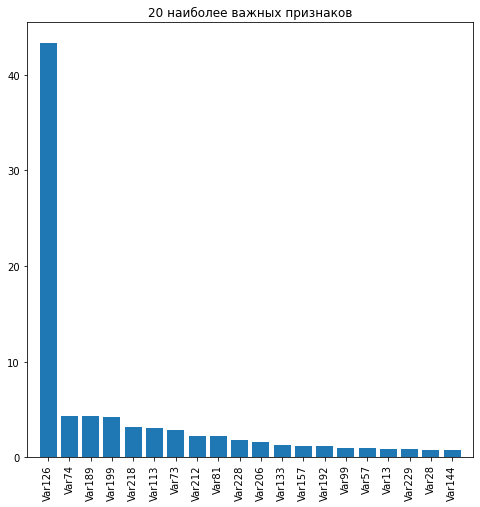

In [16]:
# построение и обучение модели
model = CatBoostClassifier(iterations=300,
                           learning_rate=0.1,
                           depth=2,
                           cat_features=cat_columns,
                           verbose=False,
                           class_weights=class_weights)
model.fit(X_2, y_2)

# обнаружение важности каждого признака
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # сортировка по убыванию важности

# визуализация важности
d_first = 20
plt.figure(figsize=(8, 8))
plt.title("20 наиболее важных признаков")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(X.columns)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

Из графика можно четко определить, что признак Var126 является самым значимым, и его важность практически сопоставима с суммой важностей каждого другого признака. Посмотрим на распределение этого признака в разрезе классов.

Populating the interactive namespace from numpy and matplotlib


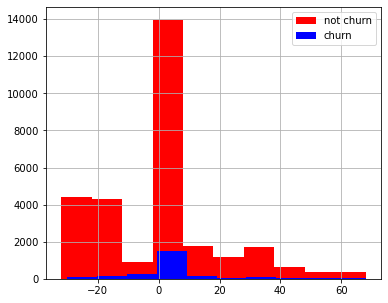

In [22]:
%pylab inline

pylab.figure(figsize(6, 5))
pylab.grid()
pylab.hist(X[y == -1].Var126, color = 'r', label = 'not churn')
pylab.hist(X[y == 1].Var126, color = 'b', label = 'churn')
pylab.legend()

pylab.show()

Из гистограммы можно понять, что при значениях Var126 отличных от нуля, скорее всего, пользователь не собирается уходить. Конечно на одном признаке выводы делать нельзя, но для простой прикидочной оценки  можно смотреть на распределения самых важных признаков.

## Оценка качества
Как было сказано выше, качество оценивается на отложенной выборке по метрике ROC AUC. Однако этого недостаточно, чтобы понять, что решение хорошее.

Обучение проводилось на всей выборке, данный был сделан на одном из этапов проекта. И с помощью кривых обучения попробую показать, что этот выбор очевиден.

In [24]:
train_sizes, train_scores, test_scores = learning_curve(model,
                                                        X, y,
                                                        train_sizes = np.linspace(0.1, 1, 10),
                                                        cv=cv, scoring='roc_auc')

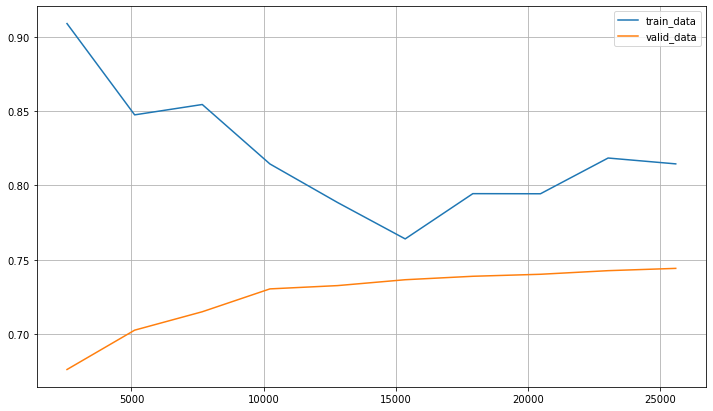

In [25]:
plt.figure(figsize=(12, 7))

plt.plot(train_sizes, train_scores.mean(axis=1), label='train_data')
plt.plot(train_sizes, test_scores.mean(axis=1), label='valid_data')
plt.legend()
plt.grid(True)

Видно, что качество на тесте растет, и если бы было еще больше данных, то можно было бы улучшить результаты.

В большинстве случаев конечно требуется предсказать вероятность того, что пользователь покинет сервис. Однако, чтобы проинтерпретировать результаты модели и подобрать нужные пороги, стоит проанализировать confusion matrix. А для этого необходимо уже предсказывать непосредственно метку.

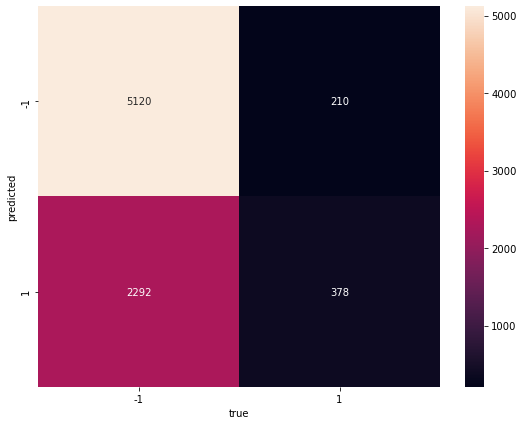

In [44]:
result_2 = pd.DataFrame({'y_true': y_test, 'y_pred': opt.predict(X_test)})
conf_matr = pd.crosstab(result_2.y_pred, result_2.y_true, rownames=['predicted'], colnames=['true'])

plt.figure(figsize=(9, 7))
seaborn.heatmap(conf_matr, annot=True, fmt='d')
plt.show()

In [50]:
precision_score(y_test, opt.predict(X_test))

0.14157303370786517

In [51]:
recall_score(y_test, opt.predict(X_test))

0.6428571428571429

В задаче прогнозирования оттока стоимость ошибки второго рода (то есть больше ошибок False Negative) выше стоимости ошибки первого рода (то есть больше ошибок False Positive). Соответственно, полнота для нас важнее точности.

Модель, которую я построил, нацелена больше на полноту, чем на точность.

Экономический эффект от построения модели оценивать крайне сложно, имея на руках только саму модель. Более правильным решением является проведение А/Б теста (например, на топ 5% сегменте случанйых пользователей). И уже на результатах А/Б теста оценить эффект воздействия.

Данный эффект желательно оценить с помощью uplift-моделирования, то есть обнаружить тех клиентов, которые отказались бы от сервера при отсутствии воздействия, но остались бы при его наличии.

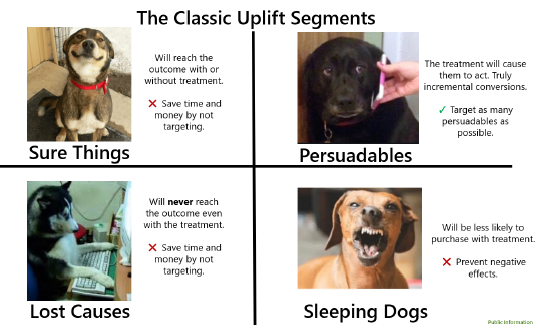

## Заключение
С помощью модели, которую я построил, можно ответить на два вопроса:
- Можно ли построить модель по предсказанию вероятности оттока?
- Какие признаки обеспечат нам наибольшую информативность, чтобы качество модели было оптимальным?

На первый вопрос можно уверенно ответить положительно, такая модель построена. В качестве ответа на второй вопрос выше был представлен график наиболее значимых признаков.

### Выводы:
1. На качество модели значительно влияет обработка категориальных признаков, поэтому была выбрана модель, которая автоматически их обрабатывает;
2. В задаче оттока полнота более значима точности;
3. В данное время для анализа результатов А/Б тестов очень популярно uplift моделирование.